In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.preprocessing import RobustScaler, StandardScaler
from tqdm import tqdm 

import sklearn.datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import sys
import shap

sys.path.append(os.path.abspath(".."))
from utils.data_utils import remove_label, process_cat_vars

shap.initjs()    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.random.seed(42)
rng = np.random.default_rng(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)


# Data Preprocessing
Including label removal, encoding categorical data and dealing with outliers

In [2]:
def remove_label(df):
    "Removes the labels (HeartDisease) from a dataframe"
    labels = df['HeartDisease'].copy()
    
    df_without_heart_disease = df.drop(columns=['HeartDisease'])
    
    return df_without_heart_disease, labels

def process_cat_vars(df):
    """
    Preprocess the data, including encoding categorical variables and 
    applying one-hot encoding to certain columns. 
    
    Parameters:
    df (DataFrame): input dataframe

    Returns:
    DataFrame: preprocessed dataframe
    """
    # Male is 1, female is 0 for 'Sex'
    df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})
    
    # 'ExerciseAngina' : Yes is 1 and No is 0
    df['ExerciseAngina'] = df['ExerciseAngina'].map({'Y': 1, 'N': 0})
    
    # 'ST_Slope': Up is 1, Flat is 0, Down is -1
    df['ST_Slope'] = df['ST_Slope'].map({'Up': 1, 'Flat': 0, 'Down': -1})

    # One hot encoding for categorical columns that have more than two categories
    df_encoded = pd.get_dummies(df, columns=['ChestPainType', 'RestingECG'], dtype=int)
    
    return df_encoded

def handle_outliers(df):
     # Set outlier cholesterol values to NaN
    df.loc[df['Cholesterol'] < 50, 'Cholesterol'] = np.nan
    df.loc[df['Cholesterol'] > 400, 'Cholesterol'] = np.nan

    # Set outlier resting BP values to NaN
    df.loc[df['RestingBP'] < 30, 'RestingBP'] = np.nan

    return df.copy()

def pre_process(df):
    df = process_cat_vars(df)
    return handle_outliers(df)

In [3]:
df_train = pd.read_csv(os.path.join('train_val_split.csv'))
df_test = pd.read_csv(os.path.join('test_split.csv'))

# Data Exploration and Visualization

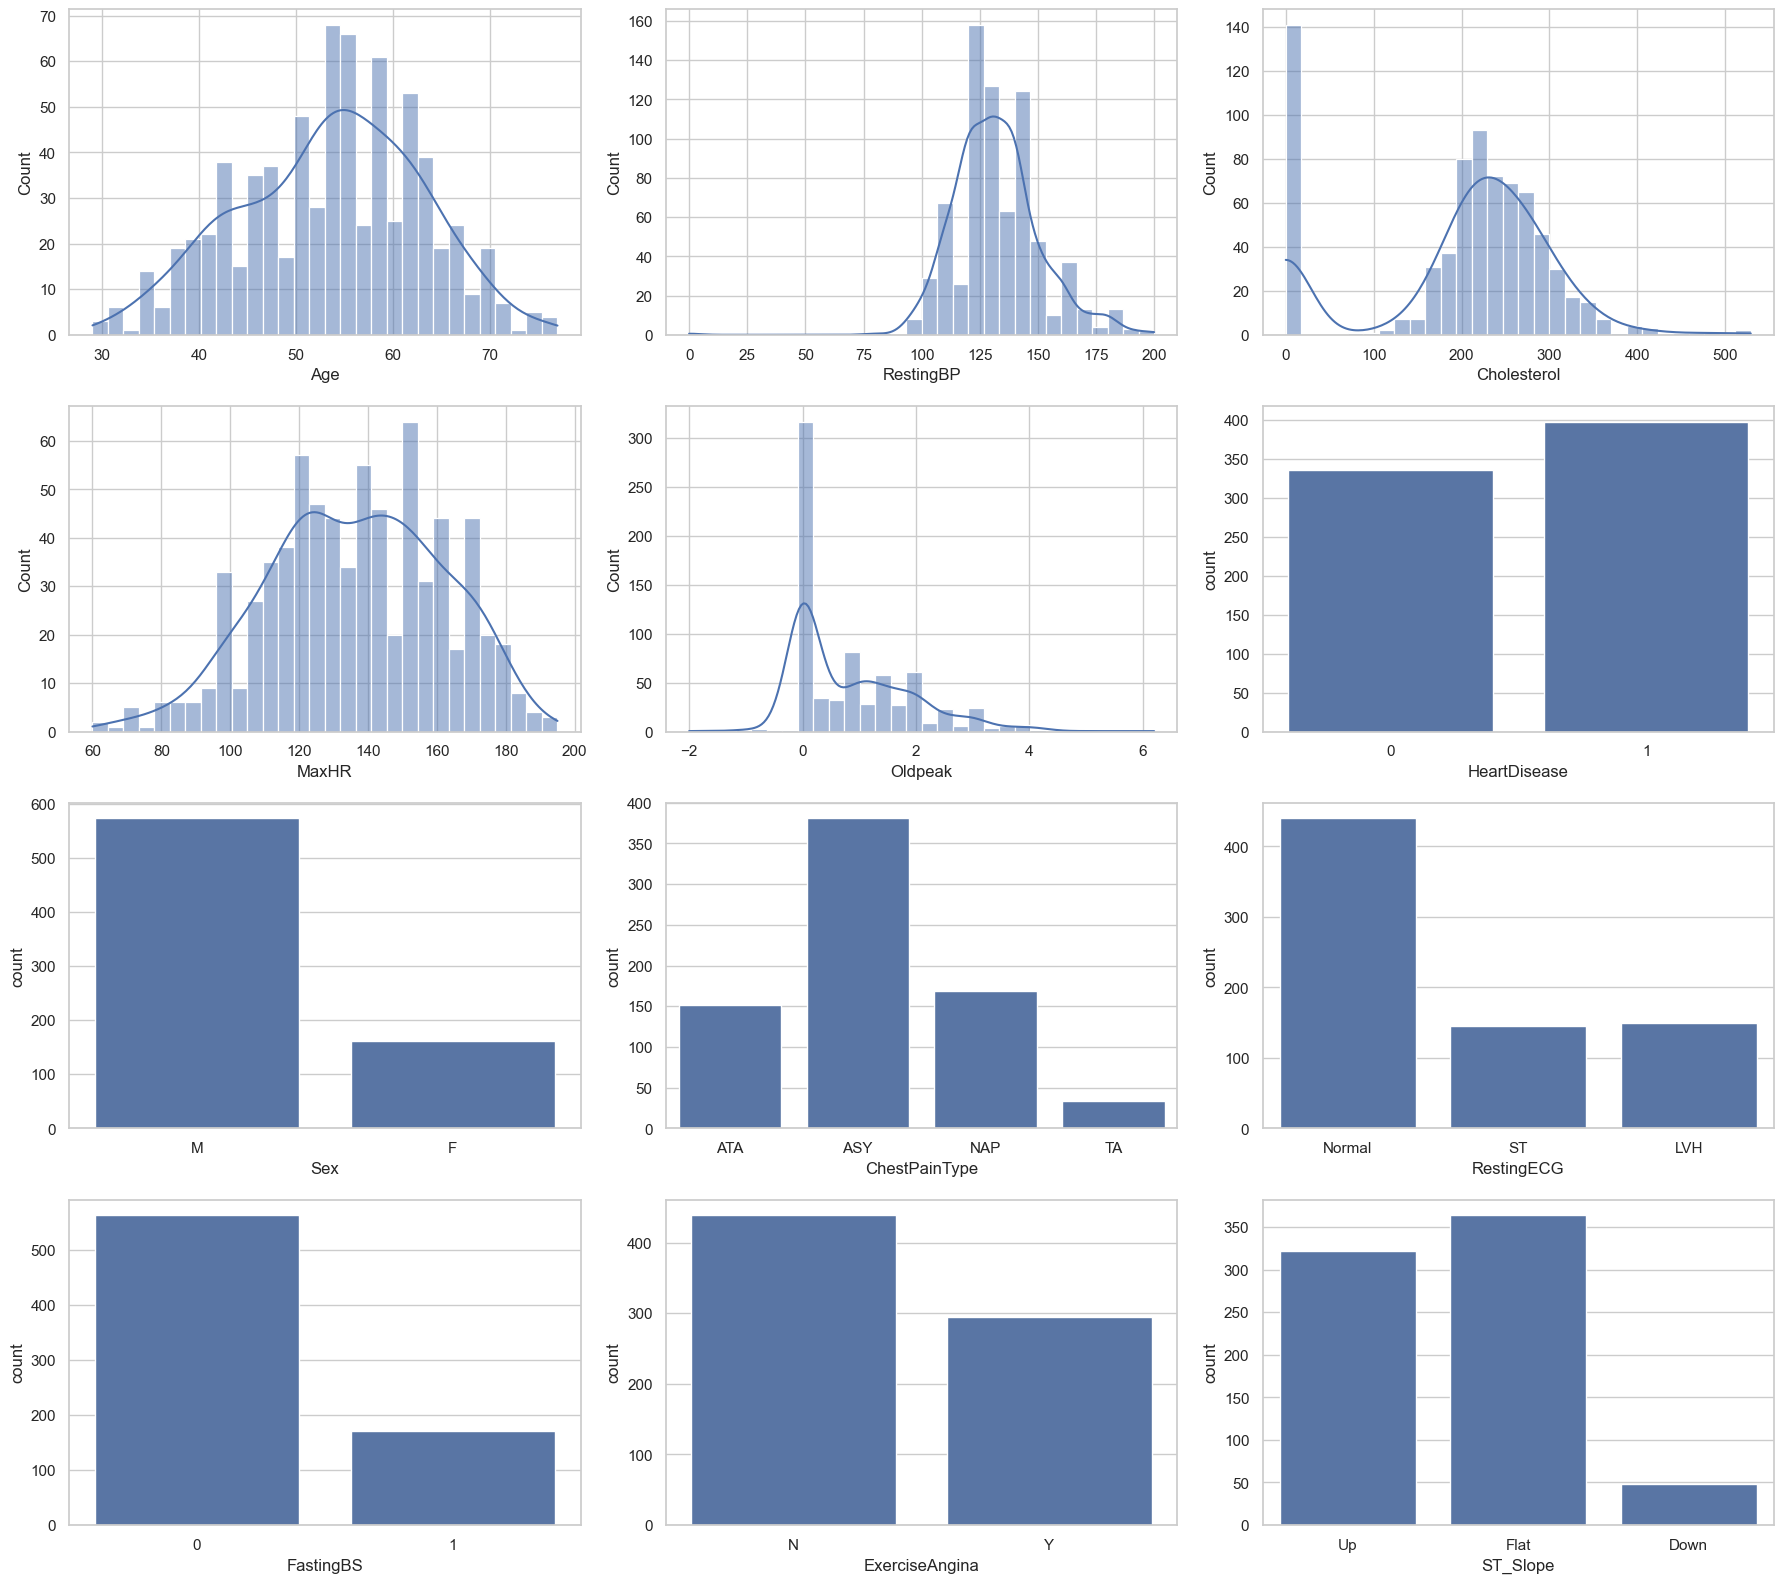

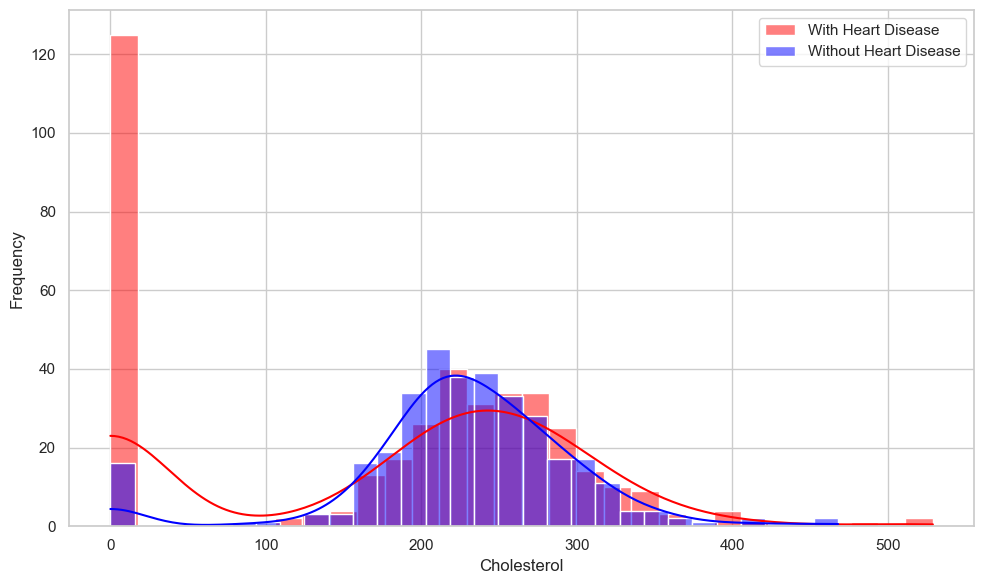

In [4]:
def plot_hists(df):
    """
    Plot distributions for numerical and categorical features in the dataset.
    
    Parameters:
    df (DataFrame): input dataframe
    """
    sns.set(style="whitegrid")
    fig, axs = plt.subplots(4, 3, figsize=(18, 16))
    axs = axs.flatten()

    numerical_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
    for i, feature in enumerate(numerical_features):
        sns.histplot(df[feature], kde=True, ax=axs[i], bins=30)

    categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'FastingBS', 'ExerciseAngina', 'ST_Slope']
    for i, feature in enumerate(categorical_features, start=6):
        sns.countplot(x=feature, data=df, ax=axs[i])

    sns.countplot(x='HeartDisease', data=df, ax=axs[5])

    plt.tight_layout()
    plt.show()


plot_hists(df_train)


cholst0 = df_train[df_train['Cholesterol'] == 0]
cholst0_summary = cholst0['HeartDisease'].value_counts()

Rbp_0 = df_train[df_train['RestingBP'] == 0]
Rbp_0_summary = Rbp_0['HeartDisease'].value_counts()

#print("HeartDisease labels for entries with Cholesterol = 0:")
#print(cholst0_summary)

#print("\nHeartDisease labels for entries with RestingBP = 0:")
#print(Rbp_0_summary)

disease_df = df_train[df_train['HeartDisease'] == 1]
no_disease_df = df_train[df_train['HeartDisease'] == 0]

# Set up the plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the distribution for patients with heart disease
sns.histplot(disease_df['Cholesterol'], kde=True, color='red', bins=30, label='With Heart Disease')

# Plot the distribution for patients without heart disease
sns.histplot(no_disease_df['Cholesterol'], kde=True, color='blue', bins=30, label='Without Heart Disease')

# Adding title and labels
plt.xlabel('Cholesterol')
plt.ylabel('Frequency')

# Show legend
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


# Data Preprocessing

In [5]:
X_train, Y_train = remove_label(df_train)
X_test, Y_test = remove_label(df_test)

df_train_nlp = X_train.copy()
df_test_nlp = X_test.copy()

X_train = pre_process(X_train)
X_test = pre_process(X_test)

cholesterol_median = X_train['Cholesterol'].median()
restingbp_median = X_train['RestingBP'].median()

X_train['Cholesterol'] = X_train['Cholesterol'].fillna(cholesterol_median)
X_train['RestingBP'] = X_train['RestingBP'].fillna(restingbp_median)

X_test['Cholesterol'] = X_test['Cholesterol'].fillna(cholesterol_median)
X_test['RestingBP'] = X_test['RestingBP'].fillna(restingbp_median)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
We investigate Lasso Regression performance and looka at it coeffiecients to determine, which features are important for the prediction.

F1 Score: 0.857
Balanced Accuracy: 0.815
              precision    recall  f1-score   support

           0       0.80      0.76      0.78        74
           1       0.84      0.87      0.86       110

    accuracy                           0.83       184
   macro avg       0.82      0.81      0.82       184
weighted avg       0.83      0.83      0.83       184



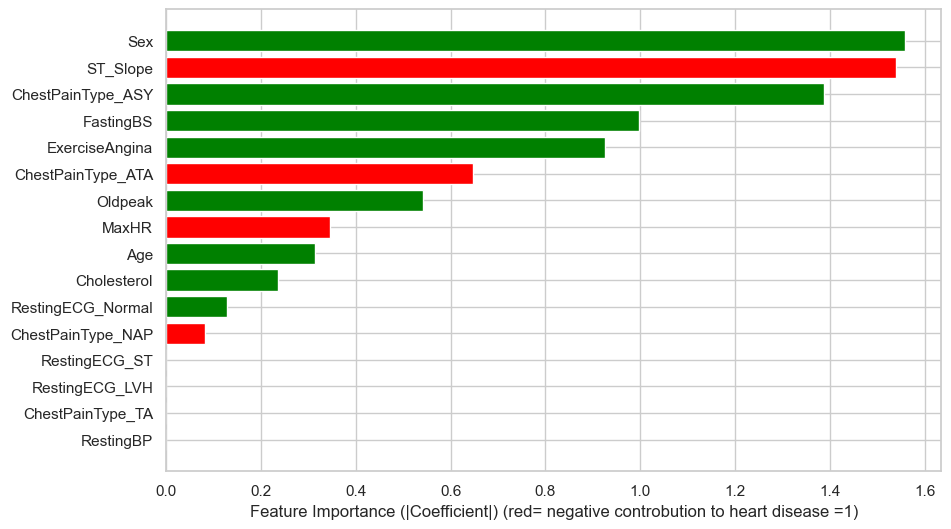

In [6]:
log_lasso_model = LogisticRegression(penalty='l1', C=1, solver='liblinear', random_state=30)  # C is the inverse of alpha
log_lasso_model.fit(X_train_scaled, Y_train)
coefficients = log_lasso_model.coef_.flatten()

coefficients.size

feature_names = X_train.columns
feature_names.size
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Predictions
y_pred_binary = log_lasso_model.predict(X_test_scaled)


f1 = f1_score(Y_test, y_pred_binary)
balanced_accuracy = balanced_accuracy_score(Y_test, y_pred_binary)

print(f"F1 Score: {f1:.3f}")
print(f"Balanced Accuracy: {balanced_accuracy:.3f}")

# Detailed classification report
print(classification_report(Y_test, y_pred_binary))

# Q2.4: Visualize the Feature Importance
# Plot feature importance (absolute value of coefficients)

# Calculate importance and sort
feature_importance = np.abs(coefficients)
sorted_idx = np.argsort(feature_importance)[::-1]
sorted_coefficients = coefficients[sorted_idx]
sorted_features = feature_names[sorted_idx]

# Assign colors based on sign
colors = ['green' if coef > 0 else 'red' for coef in sorted_coefficients]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, feature_importance[sorted_idx], align='center', color=colors)
plt.xlabel('Feature Importance (|Coefficient|) (red= negative controbution to heart disease =1)')
plt.gca().invert_yaxis()  # optional: highest importance on top
plt.savefig('P1_Q2_lasso_feat_imp_plot.png', dpi=300, bbox_inches='tight')

# NAM
We train a Neural Additive Model (NAM), which combines the expressivity of Deep Neural networks with the interpretability of generalized additive
models.

In [7]:
class ActivationLayer(nn.Module):
    def __init__(self, input_dim, num_units, activation='relu'):
        super().__init__()
        self.activation = activation
        if activation == 'relu':
            self.linear = nn.Linear(input_dim, num_units)
        elif activation == 'exu':
            self.beta = nn.Parameter(torch.empty(input_dim, num_units))
            self.c = nn.Parameter(torch.empty(1, num_units))
            nn.init.trunc_normal_(self.beta, mean=4.0, std=0.5)
            nn.init.trunc_normal_(self.c, std=0.5)
        else:
            raise ValueError("Unsupported activation type. Use 'relu' or 'exu'.")

    def forward(self, x):
        if self.activation == 'relu':
            return F.relu(self.linear(x))
        elif self.activation == 'exu':
            center = self.c.expand(x.shape[0], -1)
            return torch.clamp(torch.exp(self.beta) * (x - center), 0, 1)

class FeatureNN(nn.Module):
    def __init__(self, num_units, feature_idx, activation='relu'):
        super().__init__()
        self.activation = ActivationLayer(1, num_units, activation=activation)
        self.hidden1 = nn.Linear(num_units, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.linear = nn.Linear(32, 1, bias=False)
        self.feature_idx = feature_idx

    def forward(self, x):
        x = x[:, self.feature_idx].unsqueeze(1)  
        x = self.activation(x)                 
        x = F.relu(self.hidden1(x))             
        x = F.relu(self.hidden2(x))            
        x = self.linear(x)                     
        return x.squeeze(1)                     

# NAM model
class NAM(nn.Module):
    def __init__(self, input_dim, num_units=64, activation='relu'):
        super().__init__()
        self.feature_nns = nn.ModuleList([
            FeatureNN(num_units=num_units, feature_idx=i, activation=activation) for i in range(input_dim)
        ])
        self.bias = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        outputs = [fnn(x) for fnn in self.feature_nns]  # list of [batch_size]
        return torch.sigmoid(torch.stack(outputs, dim=1).sum(dim=1) + self.bias)


In [8]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=50, lr=0.001, batch_size=64):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    pos_weight = torch.tensor([Y_train.value_counts()[0] / Y_train.value_counts()[1]], dtype=torch.float32)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val.values, dtype=torch.float32))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        with torch.no_grad():
            val_preds = torch.cat([model(xb.to(device)) for xb, _ in val_loader]).cpu().numpy()
            val_labels = torch.cat([yb for _, yb in val_loader]).numpy()
            val_preds_binary = (val_preds >= 0.5).astype(int)
            acc = accuracy_score(val_labels, val_preds_binary)
            f1 = f1_score(val_labels, val_preds_binary)
            print(f"Epoch {epoch+1}: Loss={epoch_loss:.4f}, Accuracy={acc:.4f}, F1={f1:.4f}")

    return model

# Evaluation function
def evaluate_model(model, X_test, y_test):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    with torch.no_grad():
        preds = model(X_tensor).cpu().numpy()
    preds_binary = (preds >= 0.5).astype(int)
    acc = accuracy_score(y_test, preds_binary)
    f1 = f1_score(y_test, preds_binary)
    bal_acc = balanced_accuracy_score(y_test, preds_binary)
    print(f"Test Accuracy: {acc:.4f}, F1-score: {f1:.4f}, Balanced Accuracy: {bal_acc:.4f}")
    return #preds
    
# Visualization of learned feature functions
def plot_feature_functions(model, feature_names, X):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    fig, axes = plt.subplots(len(feature_names)//2, 2, figsize=(12, len(feature_names)*2))
    axes = axes.flatten()
    for i, (name, fnn) in enumerate(zip(feature_names, model.feature_nns)):
        print(name)
        vals = torch.linspace(X[:, i].min(), X[:, i].max(), steps=100).to(device)
        input_matrix = torch.zeros((100, X.shape[1]), device=device)
        input_matrix[:, i] = vals
        with torch.no_grad():
            out = fnn(input_matrix).cpu().numpy()
        axes[i].plot(vals.cpu().numpy(), out)
        axes[i].set_title(name)
        axes[i].set_xlabel(f"{name} value")
        axes[i].set_ylabel("Contribution to logit")
        axes[i].grid(True)
    plt.tight_layout()
    plt.show()

def plot_feature_importance(model, X, feature_names):
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        contributions = []
        for i, fnn in enumerate(model.feature_nns):
            out = fnn(X_tensor).cpu().numpy()
            abs_mean = np.mean(np.abs(out))  
            contributions.append(abs_mean)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.bar(range(len(feature_names)), contributions, color='orangered', label='NAMs')
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.ylabel("Mean Absolute Score")
    plt.title("Overall Importance")
    plt.legend()
    plt.tight_layout()
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()


In [9]:
model = NAM(input_dim=X_train_scaled.shape[1], num_units=64, activation='exu')

/opt/anaconda3/envs/playground/lib/python3.9/site-packages/torch/nn/init.py:205: UserWarning: mean is more than 2 std from [a, b] in nn.init.trunc_normal_. The distribution of values may be incorrect.
  return _no_grad_trunc_normal_(tensor, mean, std, a, b, generator=generator)


In [10]:
trained_model = train_model(model, X_train_scaled, Y_train, X_test_scaled, Y_test, epochs=40)

Epoch 1: Loss=0.6148, Accuracy=0.7663, F1=0.7749
Epoch 2: Loss=0.5634, Accuracy=0.7880, F1=0.8060
Epoch 3: Loss=0.5398, Accuracy=0.8098, F1=0.8357
Epoch 4: Loss=0.5312, Accuracy=0.8098, F1=0.8341
Epoch 5: Loss=0.5277, Accuracy=0.8261, F1=0.8505
Epoch 6: Loss=0.5248, Accuracy=0.8207, F1=0.8465
Epoch 7: Loss=0.5231, Accuracy=0.8261, F1=0.8519
Epoch 8: Loss=0.5215, Accuracy=0.8370, F1=0.8598
Epoch 9: Loss=0.5210, Accuracy=0.8315, F1=0.8545
Epoch 10: Loss=0.5198, Accuracy=0.8261, F1=0.8491
Epoch 11: Loss=0.5184, Accuracy=0.8370, F1=0.8611
Epoch 12: Loss=0.5181, Accuracy=0.8424, F1=0.8676
Epoch 13: Loss=0.5166, Accuracy=0.8533, F1=0.8767
Epoch 14: Loss=0.5155, Accuracy=0.8370, F1=0.8611
Epoch 15: Loss=0.5146, Accuracy=0.8315, F1=0.8584
Epoch 16: Loss=0.5147, Accuracy=0.8370, F1=0.8585
Epoch 17: Loss=0.5133, Accuracy=0.8261, F1=0.8532
Epoch 18: Loss=0.5136, Accuracy=0.8207, F1=0.8479
Epoch 19: Loss=0.5125, Accuracy=0.8315, F1=0.8531
Epoch 20: Loss=0.5113, Accuracy=0.8261, F1=0.8491
Epoch 21:

In [11]:
evaluate_model(trained_model, X_test_scaled, Y_test)

Test Accuracy: 0.8261, F1-score: 0.8545, Balanced Accuracy: 0.8192


Age
Sex
RestingBP
Cholesterol
FastingBS
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
ChestPainType_ASY
ChestPainType_ATA
ChestPainType_NAP
ChestPainType_TA
RestingECG_LVH
RestingECG_Normal
RestingECG_ST


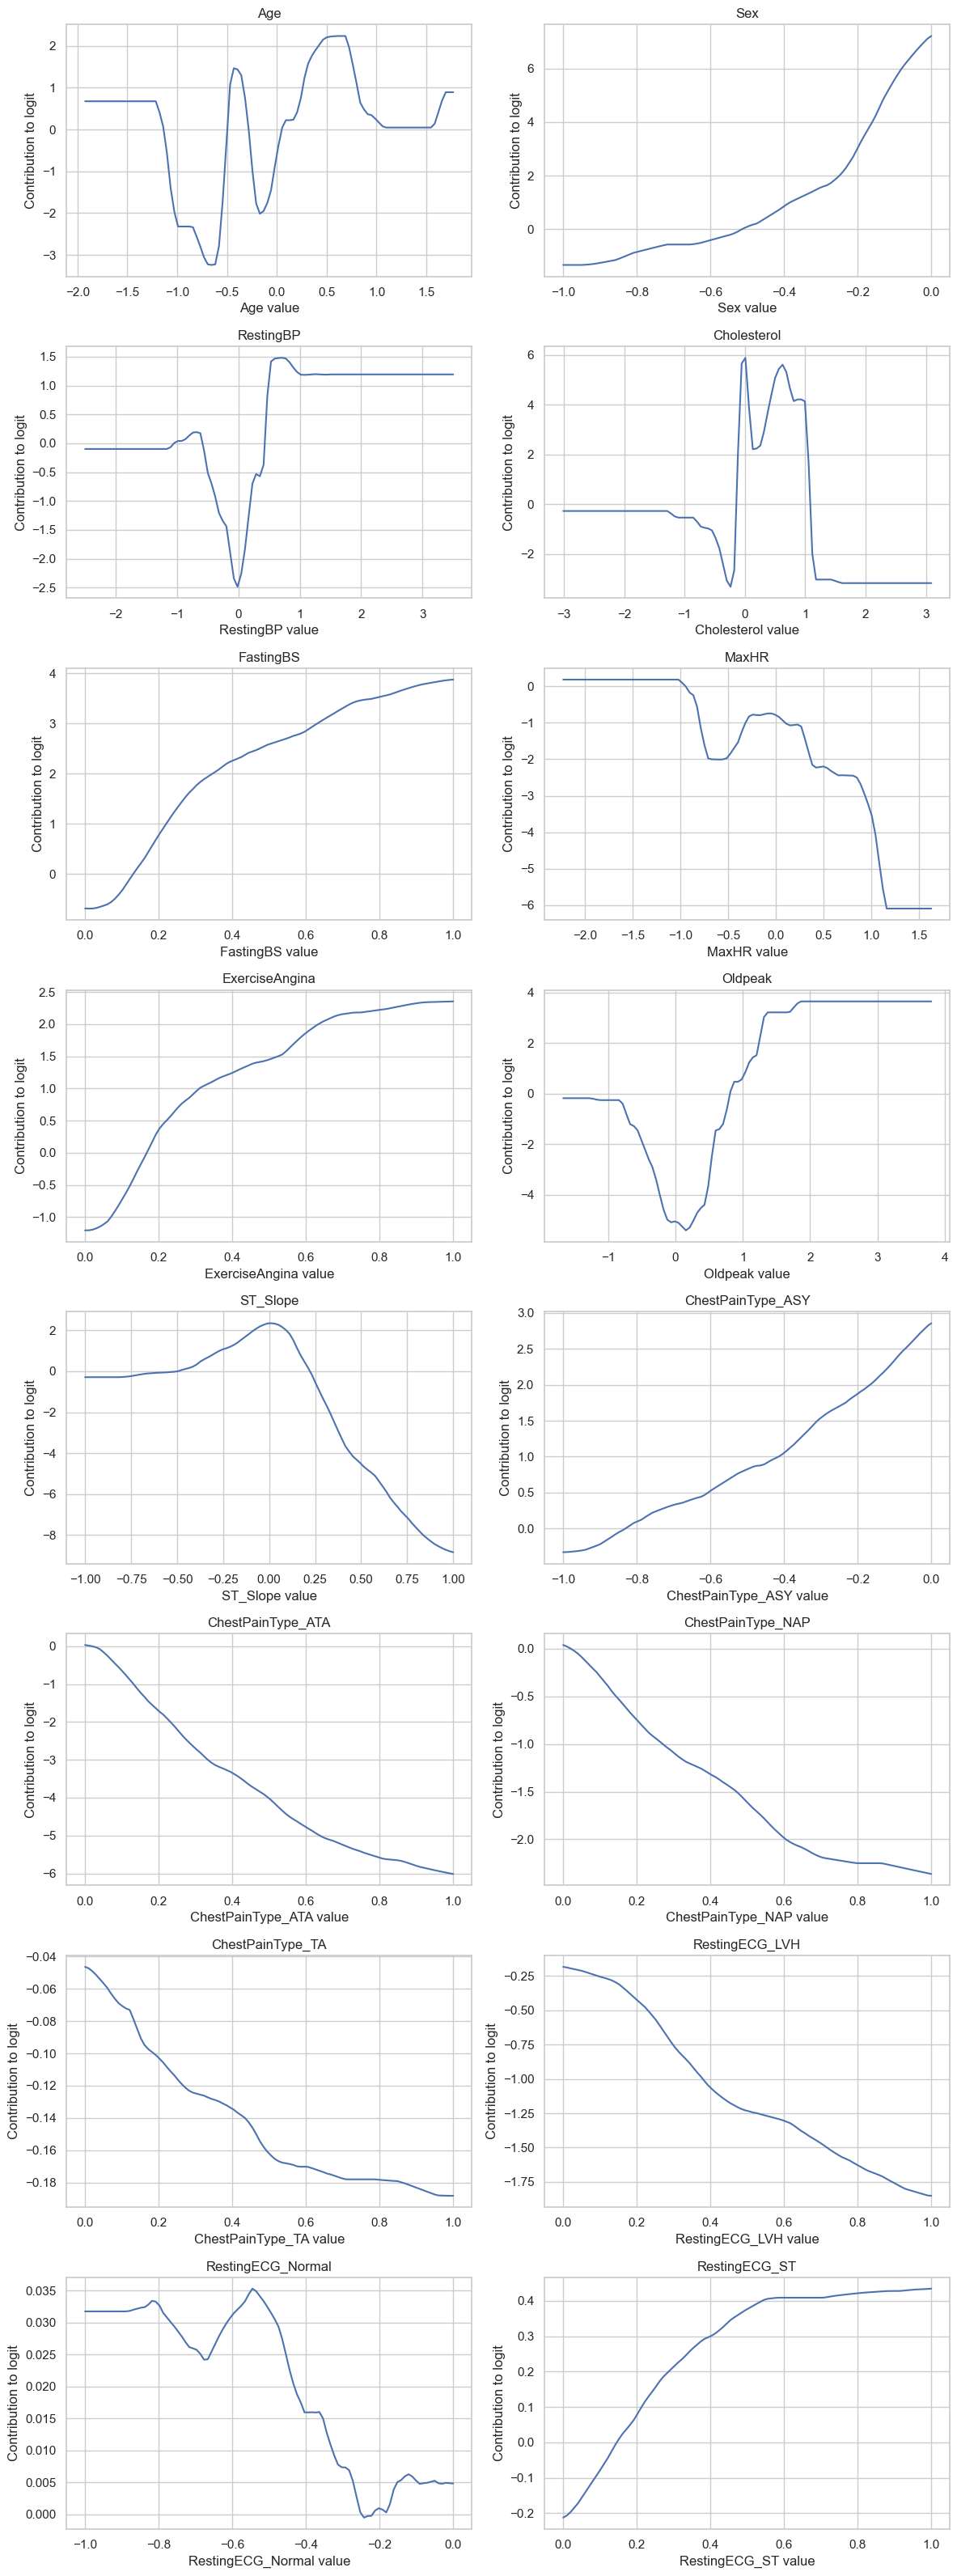

In [12]:
plot_feature_functions(trained_model, X_train.columns.tolist(), X_train_scaled)

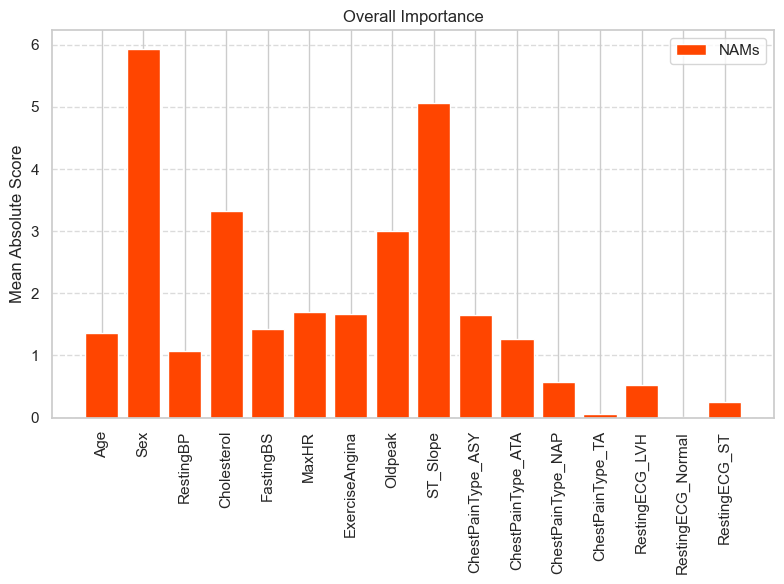

In [13]:
plot_feature_importance(trained_model, X_train_scaled, X_train.columns.tolist())

# MLP

We will investigate the performance of a simple two hidden layer ReLu MLP and furthermore we investigate the explainability of the model using SHAP. Before that we do the same preprocessig from the above.

In [14]:
X_train, Y_train = remove_label(df_train)
X_test, Y_test = remove_label(df_test)

df_train_nlp = X_train.copy()
df_test_nlp = X_test.copy()

X_train = pre_process(X_train)
X_test = pre_process(X_test)

cholesterol_median = X_train['Cholesterol'].median()
restingbp_median = X_train['RestingBP'].median()

X_train['Cholesterol'] = X_train['Cholesterol'].fillna(cholesterol_median)
X_train['RestingBP'] = X_train['RestingBP'].fillna(restingbp_median)

X_test['Cholesterol'] = X_test['Cholesterol'].fillna(cholesterol_median)
X_test['RestingBP'] = X_test['RestingBP'].fillna(restingbp_median)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
Y_train = torch.tensor(Y_train).to(device)
Y_test = torch.tensor(Y_test).to(device)



In [15]:
class MLP(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.relu1 = torch.nn.ReLU()
        self.relu2 = torch.nn.ReLU()
        self.fc4 = torch.nn.Linear(hidden_size, hidden_size*2)
        self.fc3 = torch.nn.Linear(hidden_size*2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc4(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x

model = MLP(input_size=16, hidden_size=64, output_size=1).to(device)

Epochs: 100%|██████████| 75/75 [00:00<00:00, 85.42epoch/s]


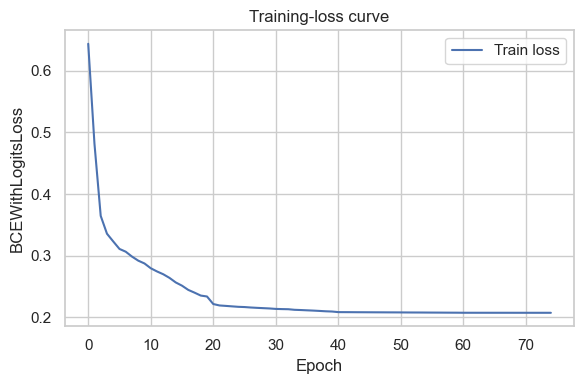

In [16]:
batch_size = 32
learning_rate = 0.001
num_epochs = 75
train_dataset = torch.utils.data.TensorDataset(X_train_scaled, Y_train)
train_loader  = DataLoader(train_dataset,
                           batch_size=batch_size,
                           shuffle=True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion  = torch.nn.BCEWithLogitsLoss()

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

loss_history = []

for epoch in tqdm(range(1, num_epochs + 1), desc="Epochs", unit="epoch"):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        logits = model(X_batch)
        y_batch = y_batch.float().unsqueeze(1)
        loss   = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
       

        running_loss += loss.item() * X_batch.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)

    scheduler.step()    

plt.figure(figsize=(6, 4))          
plt.plot(loss_history, label="Train loss")
plt.xlabel("Epoch")
plt.ylabel("BCEWithLogitsLoss")
plt.title("Training-loss curve")
plt.grid(True)
plt.legend()
plt.tight_layout()             
plt.show()


In [17]:
batch_size = 1

test_dataset = torch.utils.data.TensorDataset(X_test_scaled, Y_test)
test_loader  = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=False)

all_logits = []
all_labels = []
test_running_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        logits = model(X_batch) 
        y_batch = y_batch.float().unsqueeze(1)                   
        loss   = criterion(logits, y_batch)

        test_running_loss += loss.item() * X_batch.size(0)

        all_logits.append(logits.cpu())
        all_labels.append(y_batch.cpu())

test_loss = test_running_loss / len(test_loader.dataset)
logits  = torch.cat(all_logits).squeeze()        
targets = torch.cat(all_labels).squeeze()         

probs = torch.sigmoid(logits)                   
preds = (probs >= 0.5).int() 
f1  = f1_score(targets.numpy(), preds.numpy())
bal = balanced_accuracy_score(targets.numpy(), preds.numpy())   # add this

print(f"Average test loss: {test_loss:.4f}")
print(f"Test F1 score   : {f1:.4f}")
print(f"Balanced ACC    : {bal:.4f}")     
accuracy = (preds == targets).float().mean()                
print(f"Test accuracy   : {accuracy:.4f}")

Average test loss: 0.4358
Test F1 score   : 0.8734
Balanced ACC    : 0.8262
Test accuracy   : 0.8424


## SHAP summary plot
We plot the shapley values of each feature for each patient to determine which features are important for the model to reach the prediction.

/var/folders/v9/_5syljlj46x7sjwvgknn5gmr0000gn/T/ipykernel_2406/2783951281.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


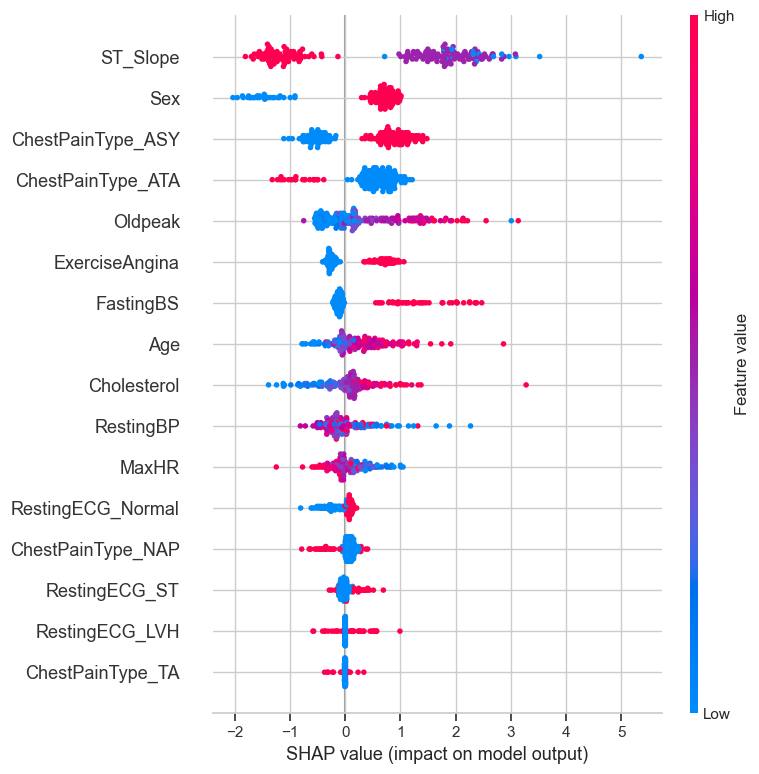

In [18]:
model.eval()

background = X_train_scaled[:100]   
explainer = shap.DeepExplainer(model, background)
data = X_test_scaled
shap_vals = explainer.shap_values(data).squeeze()
shap.summary_plot(
    shap_vals,
    data.cpu().numpy(),         
    feature_names=X_test.columns,
    plot_type="dot",
    show=True,
); 

## Waterfall plots for some selected patients
We will investigate how the model predicted the outcomes for two positive and two negative samples.

In [19]:
positive_indices = [i for i, x in enumerate(Y_test) if x == 1][:2]
negative_indices = [i for i, x in enumerate(Y_test) if x == 0][:2]

print("Positive indices:", positive_indices)
print("Negative indices:", negative_indices)

Positive indices: [0, 1]
Negative indices: [6, 10]


## Positives

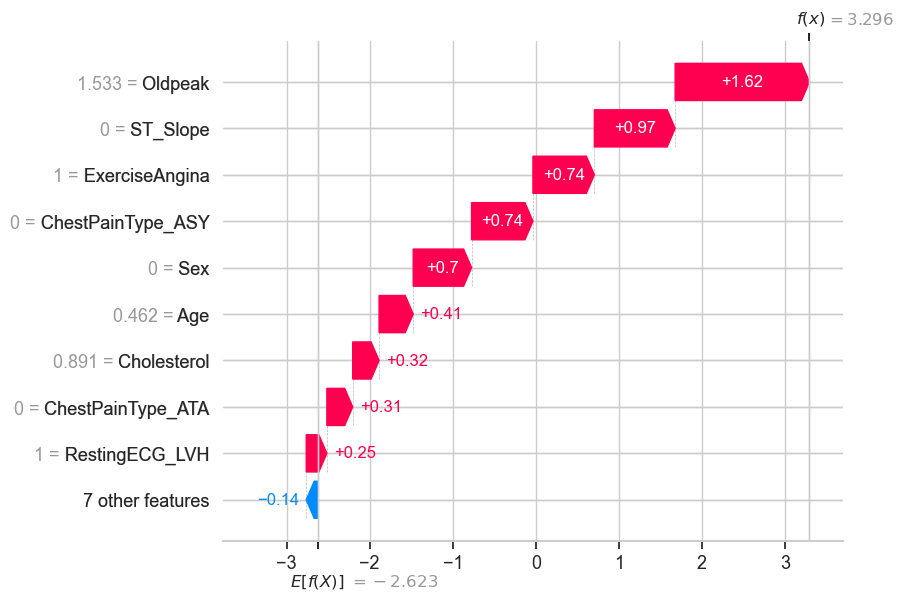

In [20]:
i = 0
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= X_test.columns.tolist()
        ),
        max_display=10, show=True
    )

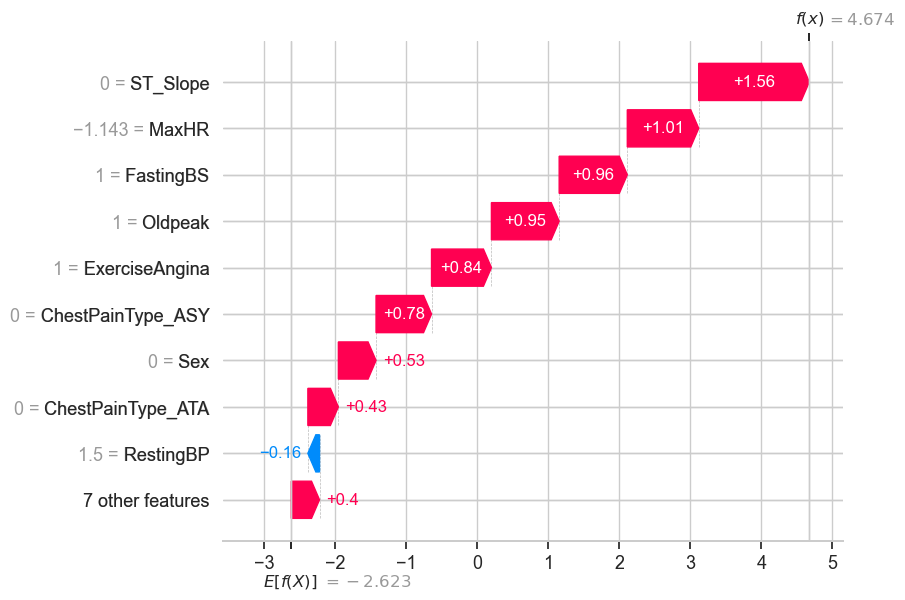

In [21]:
i = 1
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= X_train.columns.tolist()
        ),
        max_display=10, show=True
    )

## Negatives

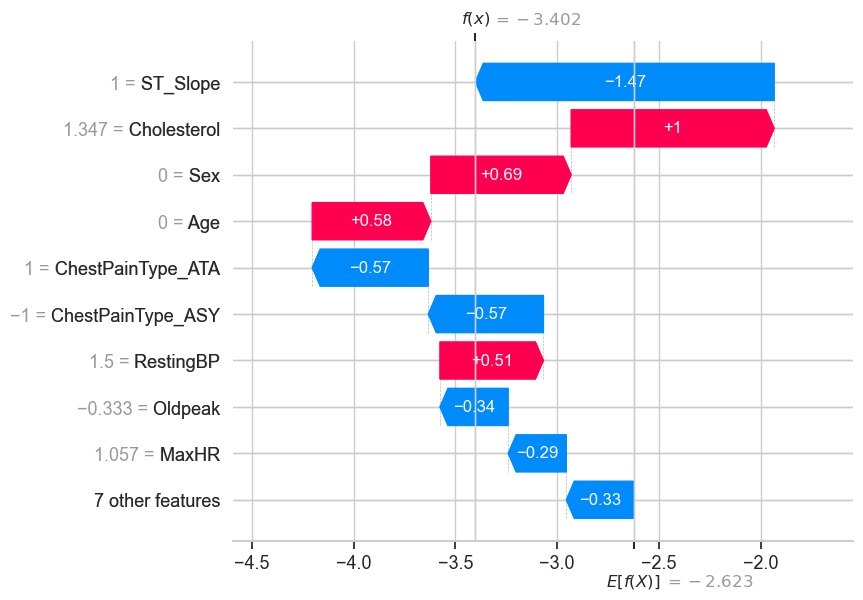

In [22]:
i = 6
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= X_train.columns.tolist()
        ),
        max_display=10, show=True
    )

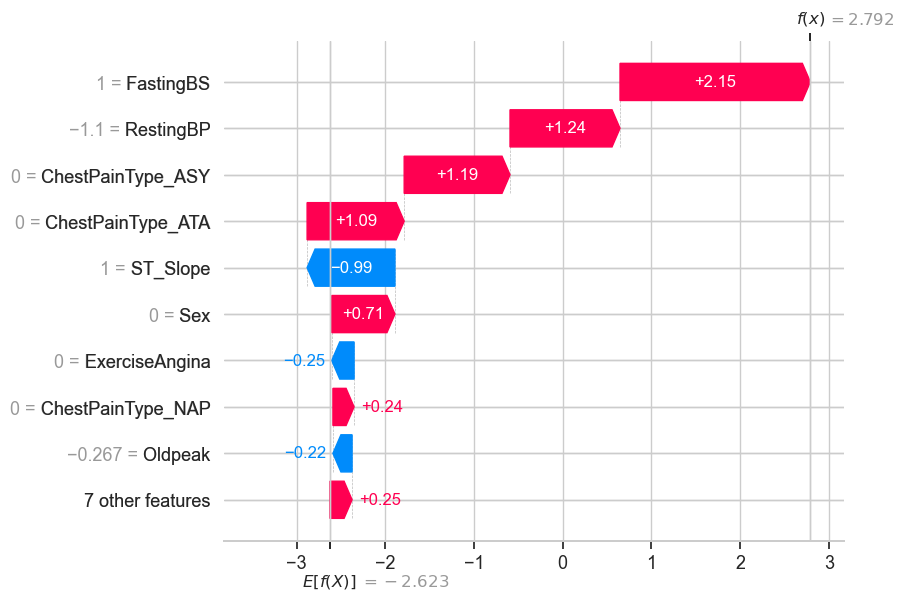

In [23]:
i = 10
sample_data  = data[i]
sample_shap  = shap_vals[i]
shap.plots.waterfall(
        shap.Explanation(
            values       = sample_shap,
            base_values  = explainer.expected_value,
            data         = sample_data.cpu().numpy(),
            feature_names= X_train.columns.tolist()
        ),
        max_display=10, show=True
    )